# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

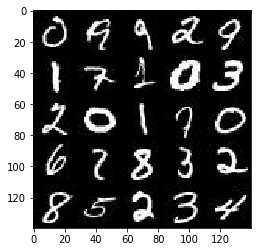

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

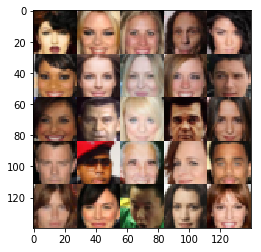

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [64]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [65]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64,5,strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        #14x14x64
        #print(relu1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        #print(relu2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # size 5x5x256
        #print(relu3)
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 5*5*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1,5,5,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        #print(x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha* x2, x2)
        #print(x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #print(x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
       # print(logits)
        # 28x28x3 now
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [90]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss=d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [91]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [92]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [109]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in (get_batches(batch_size)):
                # TODO: Train Model
                
                steps += 1
                
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizer
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z:batch_z, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                 input_real:batch_images,
                                                   lr: learning_rate})
                # Every 100 batches, get the loss and print them out
                if (steps % 10 == 0):
                    
                    train_loss_d = sess.run(d_loss, {input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                             "Discriminator Loss: {:.4f}...".format(train_loss_d),
                             "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if (steps %100 ==0 ):
                    
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.4383... Generator Loss: 0.1609
Epoch 1/2... Discriminator Loss: 2.0073... Generator Loss: 0.2752
Epoch 1/2... Discriminator Loss: 1.6403... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.7281... Generator Loss: 0.3653
Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.3559
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 0.6275


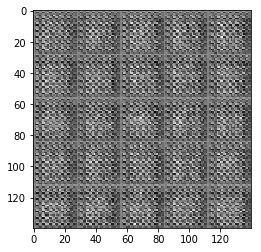

Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.6795


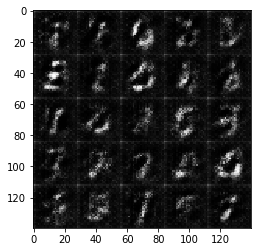

Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.8034


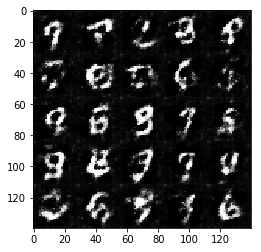

Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 0.8456


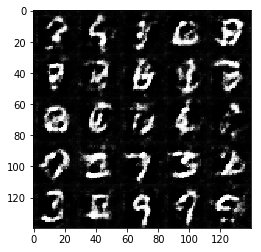

Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 0.8240


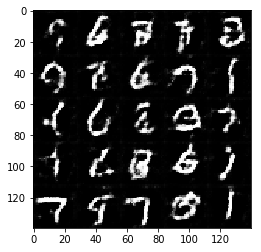

Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.0179... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.8558


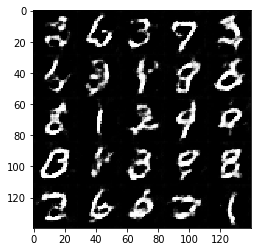

Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.9258


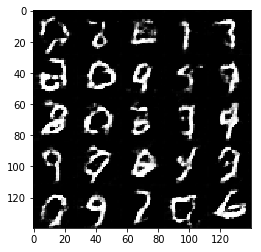

Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 0.9656... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 0.8793


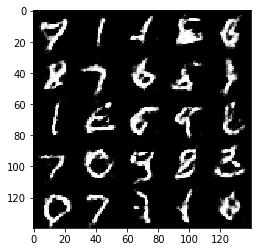

Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 1.0046
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 0.9914
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.1091
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 0.8827


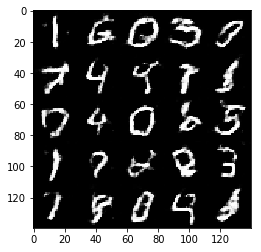

Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.9107


In [97]:
batch_size = 128
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2657... Generator Loss: 0.2180
Epoch 1/1... Discriminator Loss: 2.1555... Generator Loss: 0.2477
Epoch 1/1... Discriminator Loss: 2.0516... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 2.0121... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 1.9750... Generator Loss: 0.3161
Epoch 1/1... Discriminator Loss: 1.8347... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.6784... Generator Loss: 0.4392


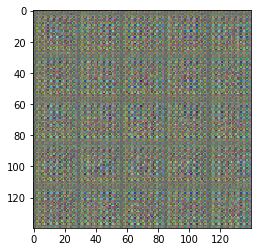

Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5338


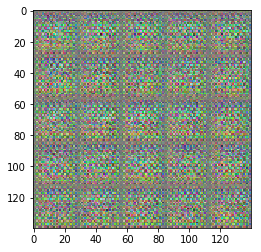

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.7939


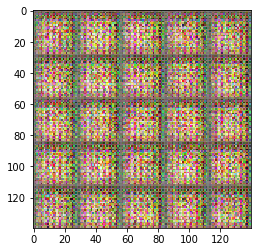

Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8294


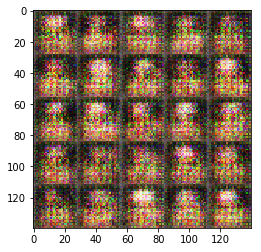

Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7835


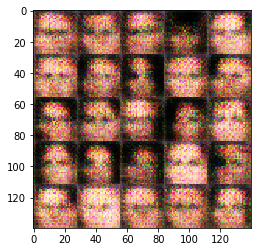

Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7242


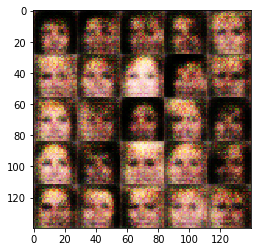

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.8016


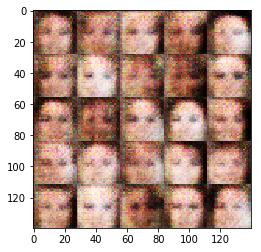

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7608


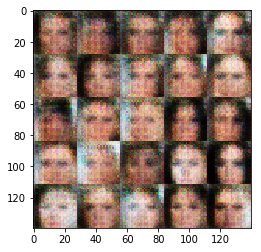

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7550


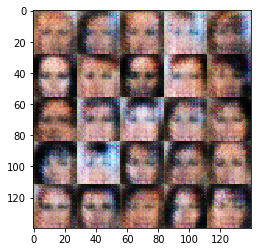

Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.8446


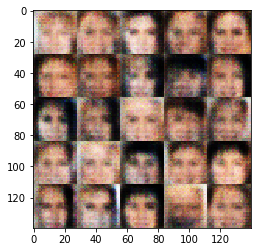

Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8298


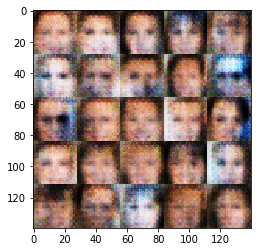

Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7767


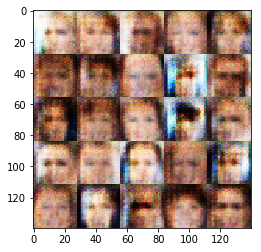

Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9218


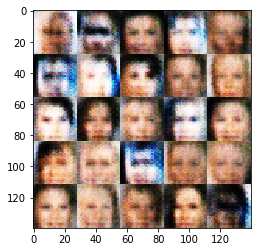

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.0266


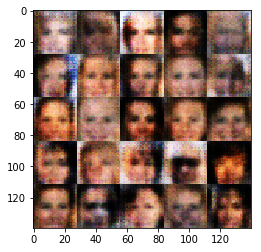

Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.9369


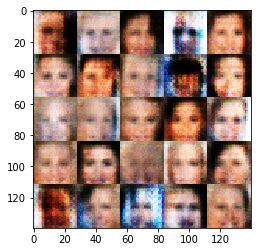

Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6967


In [115]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
  

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.